In [22]:
import os
import yaml
import glob
import time
import fitsio
import numpy as np
import twopoint
import pickle
from astropy.io import fits
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from scipy.stats import norm

In [11]:
# LOOK AT HEADERS
filen="/global/cscratch1/sd/aamon/DESImportant/2pt_NG_final_2ptblind_10_15_20_wnz.fits"
dat = fits.open(filen)
                #2pt_NG_final_2ptblind_10_15_20fg_GCharSmail.fits")
dat.info() 
print(dat[1].header)

Filename: /global/cscratch1/sd/aamon/DESImportant/2pt_NG_final_2ptblind_10_15_20_wnz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  COVMAT        1 ImageHDU        17   (900, 900)   float64   
  2  xip           1 BinTableHDU     37   200R x 8C   [K, K, K, D, D, D, D, D]   
  3  xim           1 BinTableHDU     37   200R x 8C   [K, K, K, D, D, D, D, D]   
  4  gammat        1 BinTableHDU     37   400R x 8C   [K, K, K, D, D, D, D, D]   
  5  wtheta        1 BinTableHDU     37   100R x 8C   [K, K, K, D, D, D, D, D]   
  6  nz_source     1 BinTableHDU     32   300R x 7C   [D, D, D, D, D, D, D]   
  7  nz_lens       1 BinTableHDU     31   601R x 8C   [D, D, D, D, D, D, D, D]   
  8  nz_source_realisation_0    1 BinTableHDU     36   300R x 7C   [D, D, D, D, D, D, D]   
  9  nz_source_realisation_1    1 BinTableHDU     36   300R x 7C   [D, D, D, D, D, D, D]   
 10  nz_source_realisation_2    1 BinTableHDU     36   300

write test.png


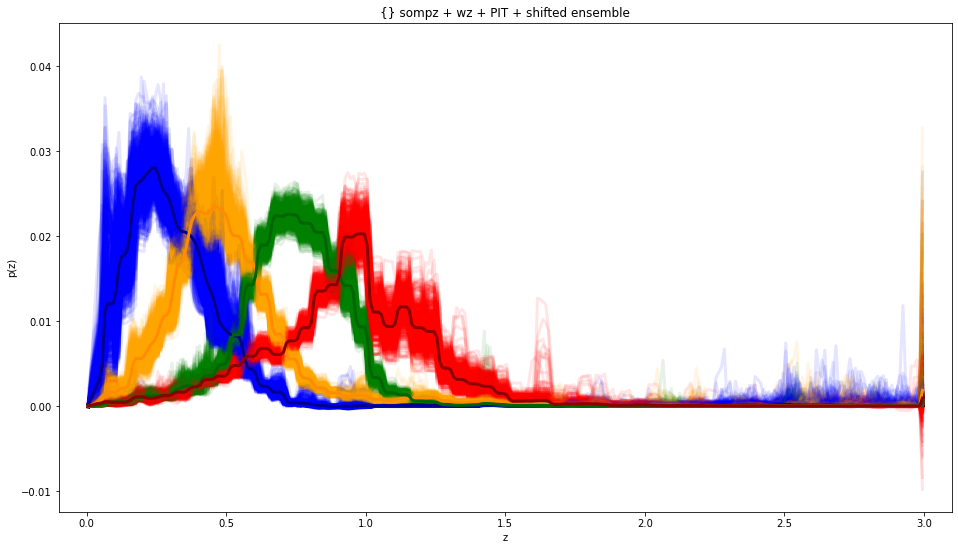

In [16]:
#PLOT NZS
def plot_ensemble_from_twopoint(infile, outfile,nrealizations):
    dat = fits.open(infile)
    #dat.info() 
    #print(dat[1].header)
    data= dat[1].data

    nz=dat['nz_source'].data
    plt.figure(figsize=(16.,9.))

    for i in range(nrealizations):
        plt.plot(dat['nz_source_realisation_{}'.format(i)].data['Z_MID'],dat['nz_source_realisation_{}'.format(i)].data['BIN1'],color='blue',lw=3, alpha=0.1)
        plt.plot(dat['nz_source_realisation_{}'.format(i)].data['Z_MID'],dat['nz_source_realisation_{}'.format(i)].data['BIN2'],color='orange',lw=3, alpha=0.1)
        plt.plot(dat['nz_source_realisation_{}'.format(i)].data['Z_MID'],dat['nz_source_realisation_{}'.format(i)].data['BIN3'],color='green',lw=3, alpha=0.1)
        plt.plot(dat['nz_source_realisation_{}'.format(i)].data['Z_MID'],dat['nz_source_realisation_{}'.format(i)].data['BIN4'],color='red',lw=3, alpha=0.1)
    plt.title('{} sompz + wz + PIT + shifted ensemble')
    plt.plot(dat['nz_source'].data['Z_MID'],dat['nz_source'].data['BIN1'],color='darkblue',lw=3)
    plt.plot(dat['nz_source'].data['Z_MID'],dat['nz_source'].data['BIN2'],color='darkorange',lw=3)
    plt.plot(dat['nz_source'].data['Z_MID'],dat['nz_source'].data['BIN3'],color='darkgreen',lw=3)
    plt.plot(dat['nz_source'].data['Z_MID'],dat['nz_source'].data['BIN4'],color='darkred',lw=3)
    plt.xlim((-0.1,3.1))
    plt.xlabel("z")
    plt.ylabel("p(z)")
    plt.savefig(outfile, dpi=150)
    print('write', outfile)

plot_ensemble_from_twopoint(filen, 'sourcenz.png',1000)  

In [38]:
#GET DELTA Z
nrealisations = 1000
nbins = 4

c = 'rgyb'
prior = '[wl_photoz_errors]\n'
nz_samples = fits.open(filen)

nz_means = np.zeros((nrealisations, nbins))

istart = 0
for i in range(2,100):
    if nz_samples[i].header['EXTNAME'] == 'nz_source_realisation_0':
        istart = i
        break

#loops over all reals
for i , ir in enumerate(range(istart, nrealisations+istart)):
    nz = nz_samples[ir].data

    for ibin in range(nbins):
        zmid = nz['Z_MID']
        nznorm=nz[f'BIN{ibin+1}']/np.sum(nz[f'BIN{ibin+1}']) #normalise
        nz_means[i, ibin] = np.sum(nznorm*zmid)

#loop over all bins
for ibin in range(nbins):
    i = ibin%2
    j = ibin//2

    zmid = nz_samples['nz_source'].data['Z_MID']
    nz = nz_samples['nz_source'].data[f'BIN{ibin+1}']

    nznorm_ref=nz/np.sum(nz) #normalise
    nz_mean_reference = np.sum(nznorm_ref*zmid)#compute mean
    print("mean of this bin: ", nz_mean_reference)

    hist = np.histogram(nz_means[:,ibin]-nz_mean_reference, bins = 'fd', density=True)
    m_mean , m_std = norm.fit(nz_means[:, ibin]-nz_mean_reference)

    prior += f'bias_{ibin+1} = gaussian 0.0 {m_std}\n'
    print(m_mean,m_std)
    
print(prior)

#f = open(nz_samples_file.replace('.fits', '_prior.ini'), 'w')
#f.write(prior)
#f.close()

mean of this bin:  0.3393439707318432
-4.418270093162002e-05 0.018271942535822993
mean of this bin:  0.5280235686155874
-6.065327916422503e-06 0.013294235498119174
mean of this bin:  0.7454877539929649
2.228933809402256e-06 0.006386381737238102
mean of this bin:  0.9339330502392676
-8.364333184086581e-07 0.012813803231689836
[wl_photoz_errors]
bias_1 = gaussian 0.0 0.018271942535822993
bias_2 = gaussian 0.0 0.013294235498119174
bias_3 = gaussian 0.0 0.006386381737238102
bias_4 = gaussian 0.0 0.012813803231689836



In [47]:
# COMPUTE M's 
dat = fits.open(filen)
norm=np.zeros((1000,4))
for i in range(0,1000): 
    for j in range(0,4):
        #print("BIN ",j+1)
        nz=dat['nz_source_realisation_{}'.format(i)].data['BIN%d'%(j+1)]
        zmid=dat['nz_source'].data['Z_MID']
        norm[i,j]=np.sum(nz) - 1

print("mean m")
for j in range(0,4):
    meanm=np.mean(norm[:,j])
    stdm=np.std(norm[:,j])
    #print(meanm, stdm)
    print(('gaussian %.5f, %.5f') %(meanm, stdm))

mean m
gaussian -0.01044, 0.00576
gaussian -0.01579, 0.00414
gaussian -0.02489, 0.00532
gaussian -0.03802, 0.00801


write lensnz.png


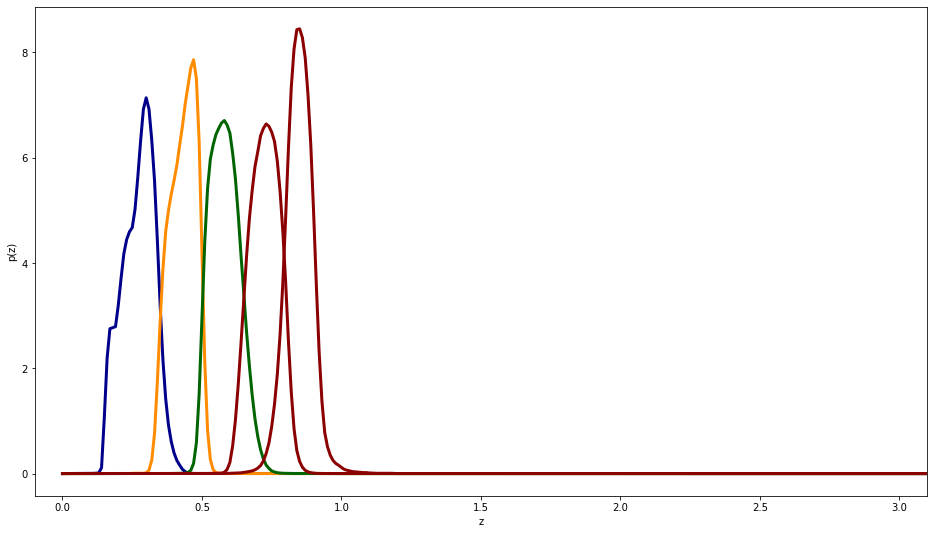

In [29]:
#  PLOT LENS NZ
def plot_lens_from_twopoint(infile, outfile):
    dat = fits.open(infile)
    #dat.info() 
    #print(dat[1].header)
    data= dat[1].data

    plt.figure(figsize=(16.,9.))
    
    plt.plot(dat['nz_lens'].data['Z_MID'],dat['nz_lens'].data['BIN1'],color='darkblue',lw=3)
    plt.plot(dat['nz_lens'].data['Z_MID'],dat['nz_lens'].data['BIN2'],color='darkorange',lw=3)
    plt.plot(dat['nz_lens'].data['Z_MID'],dat['nz_lens'].data['BIN3'],color='darkgreen',lw=3)
    plt.plot(dat['nz_lens'].data['Z_MID'],dat['nz_lens'].data['BIN4'],color='darkred',lw=3)
    plt.plot(dat['nz_lens'].data['Z_MID'],dat['nz_lens'].data['BIN5'],color='darkred',lw=3)
    plt.xlim((-0.1,3.1))
    plt.xlabel("z")
    plt.ylabel("p(z)")
    plt.savefig(outfile, dpi=150)
    print('write', outfile)
    
plot_lens_from_twopoint(filen, 'lensnz.png')

In [7]:
#MAKECOV TXT FILE IF NEEDED 

run_name = 'all_PIT_shifted_goodlowz_sompz_wz_meansamples_2609'
filen2='/global/cscratch1/sd/aamon/DESImportant/y3_Nz_covformat_%s.txt' % (run_name)

final=twopoint.TwoPointFile.from_fits(ramp55file)
np.savetxt(filen2,np.vstack((final.kernels[0].zlow,
                                   final.kernels[0].nzs[0],
                                   final.kernels[0].nzs[1],
                                   final.kernels[0].nzs[2],
                                   final.kernels[0].nzs[3])).T)

In [39]:
#CHECKS THE TWO POINT FILE HAS ANG MAX, THAT WEIRD BUG IN OLD VERSIONS OF TWOPOINT

twopt=twopoint.TwoPointFile.from_fits(filen, covmat_name=None)
print(twopt.spectra[3].angle_max)

[  3.14731353   3.96223298   4.98815579   6.27971608   7.90569415
   9.95267926  12.52968084  15.77393361  19.85820587  25.
  31.47313529  39.62232981  49.88155787  62.79716079  79.0569415
  99.52679264 125.29680841 157.73933612 198.58205868 250.
   3.14731353   3.96223298   4.98815579   6.27971608   7.90569415
   9.95267926  12.52968084  15.77393361  19.85820587  25.
  31.47313529  39.62232981  49.88155787  62.79716079  79.0569415
  99.52679264 125.29680841 157.73933612 198.58205868 250.
   3.14731353   3.96223298   4.98815579   6.27971608   7.90569415
   9.95267926  12.52968084  15.77393361  19.85820587  25.
  31.47313529  39.62232981  49.88155787  62.79716079  79.0569415
  99.52679264 125.29680841 157.73933612 198.58205868 250.
   3.14731353   3.96223298   4.98815579   6.27971608   7.90569415
   9.95267926  12.52968084  15.77393361  19.85820587  25.
  31.47313529  39.62232981  49.88155787  62.79716079  79.0569415
  99.52679264 125.29680841 157.73933612 198.58205868 250.
   3.1473135

(0.0, 3.0)

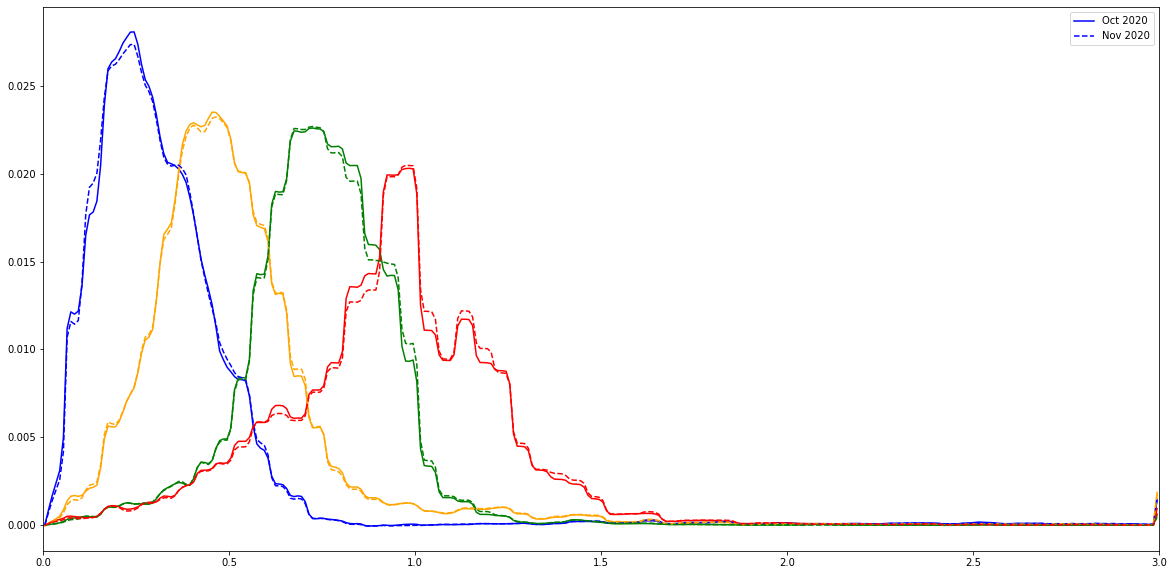

In [42]:
#COMPARE NZ TO ANOTHER
dat = fits.open(filen)
dat0 = fits.open('/global/homes/a/aamon/2pt_SOMPZWZsamples_pit_goodlowz_shifted_1000samples_ramped.055_PITfix_sim_noiseless_GCharSmail.fits')

plt.figure(figsize=(20,10))

plt.plot(dat['nz_source'].data['Z_MID'],dat['nz_source'].data['BIN1'],color='blue',ls='-',label='Oct 2020')
plt.plot(dat['nz_source'].data['Z_MID'],dat['nz_source'].data['BIN2'],color='orange',ls='-')
plt.plot(dat['nz_source'].data['Z_MID'],dat['nz_source'].data['BIN3'],color='green',ls='-')
plt.plot(dat['nz_source'].data['Z_MID'],dat['nz_source'].data['BIN4'],color='red',ls='-')

plt.plot(dat0['nz_source'].data['Z_MID'],dat0['nz_source'].data['BIN1'],color='blue',ls='--',label='Nov 2020')
plt.plot(dat0['nz_source'].data['Z_MID'],dat0['nz_source'].data['BIN2'],color='orange',ls='--')
plt.plot(dat0['nz_source'].data['Z_MID'],dat0['nz_source'].data['BIN3'],color='green',ls='--')
plt.plot(dat0['nz_source'].data['Z_MID'],dat0['nz_source'].data['BIN4'],color='red',ls='--')

plt.legend()
plt.xlim((0,3))

-98.99999999999999


(0.0, 2.0)

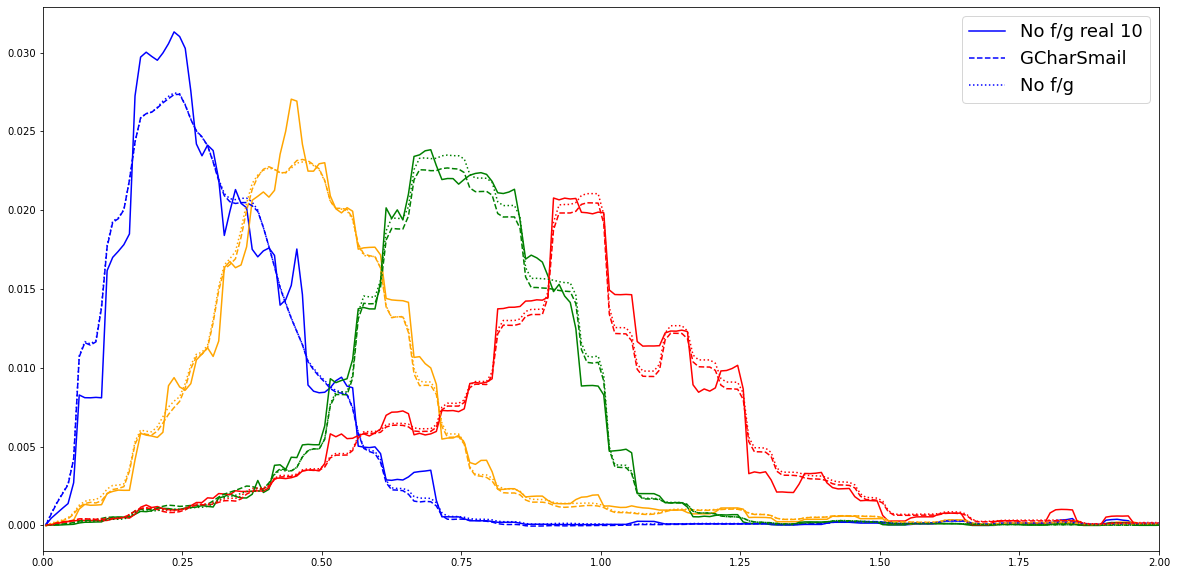

In [38]:

dat0 = fits.open('/global/homes/a/aamon/2pt_NG_BLINDED_v0.40cov_xcorrGGL_27072020_SOMPZWZsamples_pit_shifted_1000samples_ramped.055_2609_GCharSmail.fits')
dat = fits.open('/global/homes/a/aamon/2pt_NG_BLINDED_v0.40cov_xcorrGGL27072020_1000samples_055ramp_all_2609_meanzisreal10.fits')
dat1 = fits.open('/global/homes/a/aamon/2pt_NG_BLINDED_v0.40cov_xcorrGGL27072020_1000samples_055ramp_all_2609.fits')

plt.figure(figsize=(20,10))
print(1-np.sum(dat['nz_source'].data['BIN1']))
plt.plot(dat['nz_source'].data['Z_MID'],dat['nz_source'].data['BIN1']/(np.sum(dat['nz_source'].data['BIN1'])),color='blue',ls='-',label='No f/g real 10')
plt.plot(dat['nz_source'].data['Z_MID'],dat['nz_source'].data['BIN2']/(np.sum(dat['nz_source'].data['BIN2'])),color='orange',ls='-')
plt.plot(dat['nz_source'].data['Z_MID'],dat['nz_source'].data['BIN3']/(np.sum(dat['nz_source'].data['BIN3'])),color='green',ls='-')
plt.plot(dat['nz_source'].data['Z_MID'],dat['nz_source'].data['BIN4']/(np.sum(dat['nz_source'].data['BIN4'])),color='red',ls='-')

plt.plot(dat0['nz_source'].data['Z_MID'],dat0['nz_source'].data['BIN1'],color='blue',ls='--',label='GCharSmail')
plt.plot(dat0['nz_source'].data['Z_MID'],dat0['nz_source'].data['BIN2'],color='orange',ls='--')
plt.plot(dat0['nz_source'].data['Z_MID'],dat0['nz_source'].data['BIN3'],color='green',ls='--')
plt.plot(dat0['nz_source'].data['Z_MID'],dat0['nz_source'].data['BIN4'],color='red',ls='--')

plt.plot(dat1['nz_source'].data['Z_MID'],dat1['nz_source'].data['BIN1']/(np.sum(dat1['nz_source'].data['BIN1'])),color='blue',ls=':',label='No f/g')
plt.plot(dat1['nz_source'].data['Z_MID'],dat1['nz_source'].data['BIN2']/(np.sum(dat1['nz_source'].data['BIN2'])),color='orange',ls=':')
plt.plot(dat1['nz_source'].data['Z_MID'],dat1['nz_source'].data['BIN3']/(np.sum(dat1['nz_source'].data['BIN3'])),color='green',ls=':')
plt.plot(dat1['nz_source'].data['Z_MID'],dat1['nz_source'].data['BIN4']/(np.sum(dat1['nz_source'].data['BIN4'])),color='red',ls=':')

plt.legend(fontsize=18)

plt.xlim((0,2))
#plt.ylim((-0.1,3.4))
